In [33]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from datetime import timezone, datetime
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler 
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [34]:
imputedMeasurementsDf = pd.read_csv('../../../../../../Data/ProcessedData/KnnImputed/measurementsImputedByKnn.csv')
measurementsDf = pd.read_csv('../../../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [35]:
dateTimeDf = pd.DataFrame(measurementsDf['time'])

In [36]:
def iso8601ToDatetime():
    for i in range(len(dateTimeDf['time'])):
        timeContainer  = dateTimeDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        dateTimeDf['time'][i] = timeContainer

In [37]:
%%time

iso8601ToDatetime()

CPU times: total: 8.86 s
Wall time: 8.9 s


In [38]:
measurementsDf = dateTimeDf.join(imputedMeasurementsDf.drop(['day','month','hour'],axis = 1))

In [39]:
measurementsDf.head(20)

,time,T,Rn,H,P,CO2,sensor_id
0,2020-07-14 14:00:00,31.300000,1001.448424,44.475000,101.565847,567.750000,D0001
1,2020-07-14 15:00:00,31.333333,588.154974,45.505556,101.632854,636.361111,D0001
2,2020-07-14 16:00:00,31.451429,0.100000,47.145714,101.539128,734.000000,D0001
3,2020-07-14 17:00:00,31.161765,1042.843803,36.000000,101.501998,461.529412,D0001
4,2020-07-14 18:00:00,31.008333,1585.713833,28.436111,101.567130,400.000000,D0001
5,2020-07-14 19:00:00,30.647222,1585.713833,29.133333,101.567130,400.000000,D0001
6,2020-07-14 20:00:00,29.891429,1585.713833,28.597143,101.567130,400.000000,D0001
7,2020-07-14 21:00:00,29.118919,1585.713833,29.162162,101.567130,400.000000,D0001
8,2020-07-14 22:00:00,28.200000,1585.713833,31.611111,101.567130,400.000000,D0001
9,2020-07-14 23:00:00,28.280556,1389.856833,32.111111,101.296439,441.916667,D0001


In [40]:
measurementsDf.index =measurementsDf['time']

<AxesSubplot:xlabel='time'>

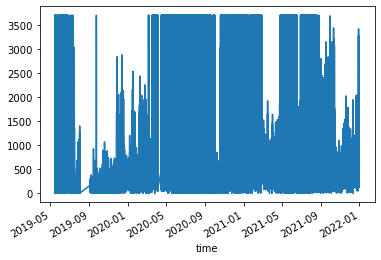

In [41]:
measurementsDf['Rn'].plot()

In [42]:
df =pd.DataFrame( measurementsDf['Rn'])
df 

,Rn
time,
2020-07-14 14:00:00,1001.448424
2020-07-14 15:00:00,588.154974
2020-07-14 16:00:00,0.100000
2020-07-14 17:00:00,1042.843803
2020-07-14 18:00:00,1585.713833
...,...
2021-12-31 19:00:00,616.640000
2021-12-31 20:00:00,541.380000
2021-12-31 21:00:00,544.167273


In [43]:
df['H'] = measurementsDf['H']
df['CO2'] = measurementsDf['CO2']
df['P'] = measurementsDf['P']
df['T'] = measurementsDf['T']
df

,Rn,H,CO2,P,T
time,,,,,
2020-07-14 14:00:00,1001.448424,44.475000,567.750000,101.565847,31.300000
2020-07-14 15:00:00,588.154974,45.505556,636.361111,101.632854,31.333333
2020-07-14 16:00:00,0.100000,47.145714,734.000000,101.539128,31.451429
2020-07-14 17:00:00,1042.843803,36.000000,461.529412,101.501998,31.161765
2020-07-14 18:00:00,1585.713833,28.436111,400.000000,101.567130,31.008333
...,...,...,...,...,...
2021-12-31 19:00:00,616.640000,50.156364,97.200000,102.653100,29.792673
2021-12-31 20:00:00,541.380000,48.047273,97.800000,102.273400,29.951673
2021-12-31 21:00:00,544.167273,53.847273,97.181818,102.199727,30.329218


In [44]:
df.head(30)

,Rn,H,CO2,P,T
time,,,,,
2020-07-14 14:00:00,1001.448424,44.475000,567.750000,101.565847,31.300000
2020-07-14 15:00:00,588.154974,45.505556,636.361111,101.632854,31.333333
2020-07-14 16:00:00,0.100000,47.145714,734.000000,101.539128,31.451429
2020-07-14 17:00:00,1042.843803,36.000000,461.529412,101.501998,31.161765
2020-07-14 18:00:00,1585.713833,28.436111,400.000000,101.567130,31.008333
2020-07-14 19:00:00,1585.713833,29.133333,400.000000,101.567130,30.647222
2020-07-14 20:00:00,1585.713833,28.597143,400.000000,101.567130,29.891429
2020-07-14 21:00:00,1585.713833,29.162162,400.000000,101.567130,29.118919
2020-07-14 22:00:00,1585.713833,31.611111,400.000000,101.567130,28.200000


In [45]:
"""scaler = StandardScaler()
scaler = scaler.fit(df)
scaled_df_for_train = scaler.transform(df)
df  = pd.DataFrame( scaled_df_for_train)
df"""

'scaler = StandardScaler()\nscaler = scaler.fit(df)\nscaled_df_for_train = scaler.transform(df)\ndf  = pd.DataFrame( scaled_df_for_train)\ndf'

In [46]:
df['Rn'].head(30)

time
2020-07-14 14:00:00    1001.448424
2020-07-14 15:00:00     588.154974
2020-07-14 16:00:00       0.100000
2020-07-14 17:00:00    1042.843803
2020-07-14 18:00:00    1585.713833
2020-07-14 19:00:00    1585.713833
2020-07-14 20:00:00    1585.713833
2020-07-14 21:00:00    1585.713833
2020-07-14 22:00:00    1585.713833
2020-07-14 23:00:00    1389.856833
2020-07-15 00:00:00    1037.712333
2020-07-15 01:00:00     423.906944
2020-07-15 02:00:00     578.023500
2020-07-15 03:00:00     706.933161
2020-07-15 04:00:00     706.933161
2020-07-15 05:00:00     423.906944
2020-07-15 06:00:00     578.657079
2020-07-15 07:00:00     429.695167
2020-07-15 08:00:00     201.446045
2020-07-15 09:00:00     124.072324
2020-07-15 10:00:00     127.271500
2020-07-15 11:00:00      30.880515
2020-07-15 12:00:00      30.567742
2020-07-15 13:00:00      30.567742
2020-07-15 14:00:00      33.053167
2020-07-15 15:00:00      33.053167
2020-07-15 16:00:00      30.880515
2020-07-15 17:00:00      30.880515
2020-07-15 18:0

In [47]:
#Converts the Df to a numpy array and then extracts the X and y value
#on the required format to train the model
def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy() # converts the dataframe to a numpy array
    #Initialized  arrays to append X and Y values 
    X = []
    y = []
    for i in range(len(df_as_np)):
        if((i + 4 + window_size)< len(df_as_np)):
            #Takes values from i to i + win size
            row =  [r for r in df_as_np[i:i+window_size]]
            X.append(row)
            #The final output
            #print(( i + window_size))
            label = df_as_np[i + 4 + window_size ][0]
            y.append(label)
    return np.array(X), np.array(y)

In [48]:
X1, y1 = df_to_X_y(df)
X1.shape, y1.shape

((115624, 6, 5), (115624,))

In [49]:
X_train, y_train = X1[:92508], y1[:92508] # training data
X_val, y_val = X1[92508:95508], y1[92508:95508] #validation
X_test, y_test = X1[95508:], y1[95508:] #test
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((92508, 6, 5), (92508,), (3000, 6, 5), (3000,), (20116, 6, 5), (20116,))

In [50]:
#X_train

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((6, 5)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [27]:
cp = ModelCheckpoint('LSTM_model/', save_best_only=True, save_format="h5")
model.compile(loss=MeanSquaredError(), 
               optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])
               #metrics=[MeanAbsoluteError()])

In [28]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
2891/2891 [==============================] - 23s 7ms/step - loss: 102681.3125 - mean_absolute_error: 160.8622 - val_loss: 51336.5117 - val_mean_absolute_error: 164.8073
INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 2/10
2891/2891 [==============================] - 17s 6ms/step - loss: 102101.5156 - mean_absolute_error: 159.9893 - val_loss: 53125.0312 - val_mean_absolute_error: 172.9239
Epoch 3/10
2891/2891 [==============================] - 18s 6ms/step - loss: 102315.5859 - mean_absolute_error: 161.8758 - val_loss: 56213.3320 - val_mean_absolute_error: 173.1514
Epoch 4/10
2891/2891 [==============================] - 18s 6ms/step - loss: 101219.6328 - mean_absolute_error: 159.1452 - val_loss: 53964.9648 - val_mean_absolute_error: 172.6459
Epoch 5/10
2891/2891 [==============================] - 14s 5ms/step - loss: 100328.1641 - mean_absolute_error: 157.4575 - val_loss: 58121.4453 - val_mean_absolute_error: 182.0389
Epoch 6/10
2891/2891 [==============================] - 15s 5ms/step - loss: 99537.5625 - mean_absolute_error: 154.9923 - val_loss: 52574.9297 - val_mean_absolute_error: 168.1503
Epoch 7/10
2891/2891 [==============================] - 16s 6ms/step - loss: 98347.8125 - mean_absolu

In [51]:
model = load_model('LSTM_model/')

In [52]:
model.metrics

In [53]:
model.evaluate(X_test,y_test)

629/629 [==============================] - 2s 2ms/step - loss: 108982.1641 - mean_absolute_error: 164.5412


[108982.1640625, 164.54122924804688]

In [54]:
plt.style.use('seaborn')

In [55]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

In [56]:
test_results.head(30)

,Test Predictions,Actuals
0,750.493225,890.230000
1,640.792480,815.413333
2,634.174011,811.605455
3,639.873840,804.932500
4,634.149780,808.569167
5,656.533386,822.270909
6,592.405640,844.027500
7,598.587341,759.144167
8,635.531921,758.683333
9,626.707275,807.364545


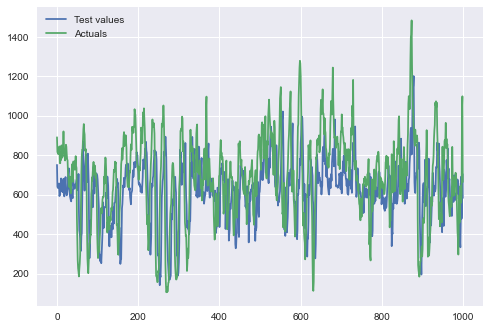

In [57]:
plt.plot(test_results['Test Predictions'][:1000])
plt.plot(test_results['Actuals'][:1000])
plt.legend(['Test values','Actuals'])